In [173]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import random
import numpy as np
import time
from datetime import datetime
from neo4j import GraphDatabase
from pymongo import MongoClient
import json

# Neo4j configuration
URI = "neo4j://localhost:7687"
AUTH = ("neo4j", "Shady5000$")

In [174]:
class UAVNetworkSimulation:
    def __init__(self, uri, auth):
        self.driver = GraphDatabase.driver(uri, auth=auth)

    def close(self):
        self.driver.close()

    def create_initial_graph(
        self, num_uavs, connection_range, ground_station_pos, backbone_range
    ):
        # Create undirected graph
        G = nx.Graph()

        # Define typical throughput and latency ranges (for example purposes)
        typical_throughput = (50, 100)  # Mbps
        typical_latency = (10, 50)  # Milliseconds
        typical_battery = (100, 100)  # %

        # Add UAV nodes with properties
        for i in range(num_uavs):
            throughput = random.randint(*typical_throughput)
            latency = random.randint(*typical_latency)
            battery = random.randint(*typical_battery)
            G.add_node(
                i,
                pos=(random.randint(0, 100), random.randint(0, 100)),
                throughput=throughput,
                latency=latency,
                battery=battery,
            )

        # Add The Backbone UAV
        backbone_uav_id = num_uavs
        G.add_node(
            backbone_uav_id,
            pos=(random.randint(0, 100), random.randint(0, 100)),
            is_backbone=True,
            throughput=throughput,
            latency=latency,
            battery=battery,
        )

        # Connect Backbone UAV to other UAVs Based on Euclidean Distance
        for i in range(num_uavs):
            pos_i = G.nodes[i]["pos"]
            pos_backbone = G.nodes[backbone_uav_id]["pos"]
            distance = np.linalg.norm(np.array(pos_i) - np.array(pos_backbone))
            if distance <= backbone_range:
                G.add_edge(i, backbone_uav_id, weight=distance)

        # Add and connect the Ground Station To The Backbone Only
        ground_station_id = num_uavs + 1
        G.add_node(
            ground_station_id,
            pos=ground_station_pos,
            is_ground_station=True,
            throughput=throughput,
            latency=latency,
            battery=battery,
        )
        G.add_edge(backbone_uav_id, ground_station_id)

        # Add edges between UAVs within connection range
        for i in range(num_uavs):
            for j in range(i + 1, num_uavs):
                pos_i = G.nodes[i]["pos"]
                pos_j = G.nodes[j]["pos"]
                distance = np.linalg.norm(np.array(pos_i) - np.array(pos_j))
                if distance <= connection_range:
                    G.add_edge(i, j, weight=distance)

        return G

    # Upload Current Graph To Neo4j
    def upload_to_neo4j(self, G):
        with self.driver.session() as session:
            # Clear existing data
            session.run("MATCH (n) DETACH DELETE n")

            # Add nodes
            for node in G.nodes:
                is_backbone = G.nodes[node].get("is_backbone", False)
                is_ground_station = G.nodes[node].get("is_ground_station", False)
                is_attack_node = G.nodes[node].get("is_attack_node", False)

                if is_backbone:
                    session.run(
                        f"""
                        CREATE (b:BackboneUAV {{id: $id, pos: $pos, uavType: $uavType,
                            throughput: $throughput, latency: $latency, battery: $battery  + '%'}})
                        """,
                        id=node,
                        pos=G.nodes[node]["pos"],
                        uavType="Backbone UAV",
                        throughput=G.nodes[node]["throughput"], 
                        latency=G.nodes[node]["latency"],
                        battery=G.nodes[node]["battery"],
                    )
                elif is_ground_station:
                    session.run(
                        f"""
                        CREATE (g:GroundStation {{id: $id, pos: $pos, uavType: $uavType, battery: $battery + '%'}})
                        """,
                        id=node,
                        pos=G.nodes[node]["pos"],
                        uavType="Ground Station",
                        battery=G.nodes[node]["battery"],
                    )  
                else:
                    session.run(
                        f"""
                        CREATE (u:UAV {{id: $id, pos: $pos, uavType: $uavType, uavName: $uavName,
                            throughput: $throughput + 'mb/s', latency: $latency + 'ms', battery: $battery + '%'}})
                        """,
                        id=node,
                        pos=G.nodes[node]["pos"],
                        uavType="UAV " + str(node),
                        uavName="UAV" + str(node),
                        throughput=G.nodes[node]["throughput"],  # noqa: F541
                        latency=G.nodes[node]["latency"],
                        battery=G.nodes[node]["battery"],
                    )

            # Add relationships
            for source, target in G.edges:
                session.run(
                    """
                    MATCH (a), (b)
                    WHERE a.id = $source AND b.id = $target
                    CREATE (a)-[:COMMUNICATES_WITH]->(b)
                    """,
                    source=source,
                    target=target,
                )

    # Draw Graph
    def draw_graph(self, G):
        pos = nx.get_node_attributes(G, "pos")

        # Labelling Each Type Of Node
        labels = {}
        for node in G.nodes:
            if G.nodes[node].get("is_backbone", False):
                labels[node] = "Backbone UAV"
            elif G.nodes[node].get("is_ground_station", False):
                labels[node] = "Ground Station"
            elif G.nodes[node].get("is_attack_node", False):
                labels[node] = "Attack Node"
            else:
                labels[node] = f"UAV{node}"

        # Differentiate node types
        regular_nodes = [
            node
            for node in G.nodes
            if not G.nodes[node].get("is_backbone", False)
            and not G.nodes[node].get("is_ground_station", False)
        ]
        backbone_nodes = [
            node for node in G.nodes if G.nodes[node].get("is_backbone", False)
        ]
        ground_station_nodes = [
            node for node in G.nodes if G.nodes[node].get("is_ground_station", False)
        ]
        attacking_nodes = [
            node for node in G.nodes if G.nodes[node].get("is_attack_node", False)
        ]

        # Draw regular UAV nodes
        nx.draw_networkx_nodes(
            G,
            pos,
            nodelist=regular_nodes,
            node_color="green",
            node_size=300,
            label="UAV",
        )

        # Draw backbone UAV node
        nx.draw_networkx_nodes(
            G,
            pos,
            nodelist=backbone_nodes,
            node_color="lightgreen",
            node_size=500,
            label="Backbone UAV",
        )

        # Draw ground station node
        nx.draw_networkx_nodes(
            G,
            pos,
            nodelist=ground_station_nodes,
            node_color="lightblue",
            node_size=500,
            label="Ground Station",
        )

        nx.draw_networkx_nodes(
            G,
            pos,
            nodelist=attacking_nodes,
            node_color="red",
            node_size=500,
            label="Attack Node",
        )

        # Draw edges
        nx.draw_networkx_edges(G, pos, edge_color="gray")

        # Draw custom labels
        nx.draw_networkx_labels(G, pos, labels)

        plt.title("Multilayer UAV Network")
        plt.legend()
        plt.show()

    def update_uav_positions(self, G, move_range):
        # Update the positions of UAVs randomly within a given range.

        for node in G.nodes:
            if (
                "is_backbone" not in G.nodes[node]
                and "is_ground_station" not in G.nodes[node]
            ):
                current_pos = G.nodes[node]["pos"]
                new_pos = (
                    current_pos[0] + random.uniform(-move_range, move_range),
                    current_pos[1] + random.uniform(-move_range, move_range),
                )
                G.nodes[node]["pos"] = new_pos
        return G

    def update_network_connections(self, G, connection_range, backbone_range):
        # Update the network connections based on new positions and connection range.
        # Excluding backbone UAV and ground station
        num_uavs = len(G.nodes) - 2
        backbone_uav_id = num_uavs

        # Update connections for regular UAVs
        for i in range(num_uavs):
            for j in range(i + 1, num_uavs):
                if G.has_edge(i, j):
                    G.remove_edge(i, j)
                pos_i = G.nodes[i]["pos"]
                pos_j = G.nodes[j]["pos"]
                distance = np.linalg.norm(np.array(pos_i) - np.array(pos_j))
                if distance <= connection_range:
                    G.add_edge(i, j, weight=distance)

        # Update connections for the Backbone UAV
        for i in range(num_uavs):
            if G.has_edge(i, backbone_uav_id):
                G.remove_edge(i, backbone_uav_id)
            pos_i = G.nodes[i]["pos"]
            pos_backbone = G.nodes[backbone_uav_id]["pos"]
            distance = np.linalg.norm(np.array(pos_i) - np.array(pos_backbone))
            if distance <= backbone_range:
                G.add_edge(i, backbone_uav_id, weight=distance)

        return G

    def update_neo4j_database(self, G):
        # Update the Neo4j database with the new positions and connections.

        with self.driver.session() as session:
            # Update positions
            for node in G.nodes:
                pos = G.nodes[node]["pos"]
                session.run(
                    """
                    MATCH (n)
                    WHERE n.id = $id
                    SET n.pos = $pos
                    """,
                    id=node,
                    pos=pos,
                )

            # Update relationships
            session.run("MATCH (n)-[r:COMMUNICATES_WITH]->() DELETE r")
            for source, target in G.edges:
                session.run(
                    """
                    MATCH (a), (b)
                    WHERE a.id = $source AND b.id = $target
                    CREATE (a)-[:COMMUNICATES_WITH]->(b)
                    """,
                    source=source,
                    target=target,
                )

    def generate_network_traffic(self, G, num_packets):
        # Generate network traffic considering the throughput of UAVs.

        packets = []
        for _ in range(num_packets):
            # Exclude backbone and ground station
            source = random.randint(0, len(G.nodes) - 3)
            target = random.randint(0, len(G.nodes) - 3)

            # Packet size should not exceed the throughput of the source UAV
            max_packet_size = G.nodes[source]["throughput"]
            size = random.randint(1, max_packet_size)

            packets.append({"source": source, "target": target, "size": size})
        return packets

    def route_packets(self, G, packets):
        # Determine the path for each packet and calculate cumulative latency.

        for packet in packets:
            source = packet["source"]
            target = packet["target"]
            if nx.has_path(G, source, target):
                path = nx.shortest_path(G, source, target)
                packet["path"] = path
                packet["delivered"] = True

                # Calculate cumulative latency
                total_latency = sum(G.nodes[node]["latency"] for node in path)
                packet["total_latency"] = total_latency
            else:
                packet["path"] = []
                packet["delivered"] = False
                packet["total_latency"] = None
        return packets

    def add_attack_node(
        self,
        G,
        target_ids,
        num_uavs,
        attack_node_pos=(random.randint(0, 100), random.randint(0, 100)),
    ):
        # Calculate a new ID for the attack node by taking the maximum current ID + 1

        attack_node_id = max(G.nodes()) + 1
        attk_battery = (100, 100)
        battery = random.randint(*attk_battery)

        # Add the attack node with specified properties
        G.add_node(
            attack_node_id,
            pos=attack_node_pos,
            uavType="Attack Node",
            is_attack_node=True,
            throughput=1000,
            latency=1,
            battery=battery,
        )

        # Directly connect the attack node to the target node
        for target_id in target_ids:
            if target_id in G.nodes():
                G.add_edge(
                    attack_node_id, target_id, weight=5
                )  # Weight can be adjusted or calculated based on actual metrics

        return attack_node_id

    def upload_attack_node_to_neo4j(self, G, attack_node_id, target_ids):
        with self.driver.session() as session:
            # Retrieve node data from the graph
            attack_node = G.nodes[attack_node_id]

            # Create the attack node in Neo4j
            session.run(
                """
                CREATE (a:AttackNode {
                    id: $id, 
                    pos: $pos,
                    uavType: $uavType,
                    throughput: $throughput, 
                    latency: $latency, 
                    battery: $battery, 
                    is_attack_node: $is_attack_node
                })
                """,
                id=attack_node_id,
                pos=str(attack_node["pos"]),
                uavType=attack_node["uavType"],
                throughput=attack_node["throughput"],
                latency=attack_node["latency"],
                battery=attack_node["battery"],
                is_attack_node=True,
            )

            # Create a relationship from the attack node to the target UAV
            for target_id in target_ids:
                if target_id in G.nodes():
                    session.run(
                        """
                        MATCH (a:AttackNode {id: $attack_id}), (u:UAV {id: $target_id})
                        CREATE (a)-[:ATTACKS]->(u)
                        """,
                        attack_id=attack_node_id,
                        target_id=target_id,
                    )

    def update_network_metrics(self, G):
        for node in G.nodes():
            # Randomly increase latency by up to 10ms and decrease throughput by up to 10 Mbps
            G.nodes[node]["latency"] = max(
                1, G.nodes[node]["latency"] + random.randint(-5, 5)
            )
            G.nodes[node]["throughput"] = max(
                1, G.nodes[node]["throughput"] + random.randint(-10, 10)
            )

    def update_network_ddos_metrics(self, G):
        for node in G.nodes():
            # Randomly increase latency by up to 10ms and decrease throughput by up to 10 Mbps
            G.nodes[node]["latency"] += random.randint(1, 5)
            G.nodes[node]["throughput"] = max(
                1, G.nodes[node]["throughput"] - random.randint(1, 10)
            )

    def run_simulation(
        self,
        G,
        total_time,
        update_interval,
        move_range,
        connection_range,
        backbone_range,
        num_packets,
    ):
        # Setup MongoDB connection
        client = MongoClient("mongodb://localhost:27017/")
        db = client["ddos_simulation"]
        db.simulation_metrics.delete_many({})
        collection = db["simulation_metrics"]
        # Run the simulation for a specified period of time.

        start_time = time.time()
        iteration = 0
        while time.time() - start_time < total_time:
            print(f"Iteration {iteration}:")

            # Update UAV positions
            self.update_uav_positions(G, move_range)
            # Update network connections
            self.update_network_connections(G, connection_range, backbone_range)
            self.update_network_metrics(G)
            self.update_neo4j_database(G)
            #self.draw_graph(G)

            packets = self.generate_network_traffic(G, num_packets)
            routed_packets = self.route_packets(G, packets)
            # Capture and record metrics for each node
            current_time = time.time() - start_time
            current_metrics = [
                {
                    "node": node,
                    "time": current_time,
                    "latency": G.nodes[node]["latency"],
                    "throughput": G.nodes[node]["throughput"],
                    "battery": G.nodes[node]["battery"],
                }
                for node in G.nodes()
            ]
            collection.insert_many(current_metrics)

            # Log the routed packets information
            for i, packet in enumerate(routed_packets):
                print(
                    f"  Packet {i}: Source: {packet['source']}, Target: {packet['target']}, "
                    f"Size: {packet['size']}, Delivered: {packet['delivered']}, "
                    f"Path: {packet['path']}, Total Latency: {packet['total_latency']}"
                )

            # Wait for the next update
            time.sleep(update_interval)
            iteration += 1
        print("Metrics have been saved to MongoDB.")
        return current_metrics

    def simulate_ddos_attack(self, G, target_ids, increase_factor, decrease_factor):
        for target_id in target_ids:
            if target_id in G.nodes():
                G.nodes[target_id]["latency"] = int(
                    G.nodes[target_id]["latency"] * increase_factor
                )
                G.nodes[target_id]["throughput"] = int(
                    G.nodes[target_id]["throughput"] * decrease_factor
                )
                G.nodes[target_id]["battery"] = int(
                    G.nodes[target_id]["battery"] * decrease_factor
                )
                # Apply effects to neighboring nodes, ensuring integer operations
                for neighbor in G.neighbors(target_id):
                    G.nodes[neighbor]["latency"] = int(
                        G.nodes[neighbor]["latency"] * (increase_factor - 0.1)
                    )
                    G.nodes[neighbor]["throughput"] = int(
                        G.nodes[neighbor]["throughput"] * (decrease_factor + 0.1)
                    )
                    # G.nodes[neighbor]['battery'] = int(G.nodes[neighbor]['battery'] * (decrease_factor + 0.1))
                    if "battery" in G.nodes[neighbor]:
                        G.nodes[neighbor]["battery"] = int(
                            G.nodes[neighbor]["battery"] * (decrease_factor + 0.1)
                        )

    def run_ddos_simulation(
        self,
        G,
        total_time,
        update_interval,
        move_range,
        connection_range,
        backbone_range,
        num_packets,
        target_ids,
    ):
        # Setup MongoDB connection
        client = MongoClient("mongodb://localhost:27017/")
        db = client["ddos_simulation"]
        db.simulation_metrics.delete_many({})
        collection = db["simulation_metrics"]

        start_time = time.time()
        iteration = 0

        while time.time() - start_time < total_time:
            print(f"Iteration {iteration}:")

            # Simulation updates
            self.update_uav_positions(G, move_range)
            # Update network connections
            self.update_network_connections(G, connection_range, backbone_range)
            self.update_network_metrics(G)
            self.update_neo4j_database(G)
            self.draw_graph(G)

            # Trigger DDoS attack
            if iteration == 1:
                self.simulate_ddos_attack(G, target_ids, 0.5, 0.5)

            # Traffic generation and routing
            packets = self.generate_network_traffic(G, num_packets)
            routed_packets = self.route_packets(G, packets)

            # Capture and log metrics
            current_metrics = [
                {
                    "node": node,
                    "time": time.time() - start_time,
                    "latency": G.nodes[node]["latency"],
                    "throughput": G.nodes[node]["throughput"],
                    "battery": G.nodes[node]["battery"],
                }
                for node in G.nodes()
            ]

            # Insert metrics into MongoDB
            collection.insert_many(current_metrics)

            # Print packet info
            for i, packet in enumerate(routed_packets):
                print(
                    f"Packet {i}: Source: {packet['source']}, Target: {packet['target']}, Size: {packet['size']}, Delivered: {packet['delivered']}, Path: {packet['path']}, Total Latency: {packet['total_latency']}"
                )

            # Delay for next update
            time.sleep(update_interval)
            iteration += 1

        print("Metrics have been saved to MongoDB.")
        return current_metrics

    def plot_time_series(self, results):
        import matplotlib.pyplot as plt

        # Filter results for a specific node for clarity, e.g., node 0
        node_results = [res for res in results if res["node_id"] == 0]
        times = [res["time"] for res in node_results]
        latencies = [res["latency"] for res in node_results]
        throughputs = [res["throughput"] for res in node_results]

        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.plot(times, latencies, marker="o", color="r")
        plt.title("Latency Over Time for Node 0")
        plt.xlabel("Time (s)")
        plt.ylabel("Latency (ms)")

        plt.subplot(1, 2, 2)
        plt.plot(times, throughputs, marker="o", color="b")
        plt.title("Throughput Over Time for Node 0")
        plt.xlabel("Time (s)")
        plt.ylabel("Throughput (Mbps)")

        plt.tight_layout()
        plt.show()

    def analyze_network(self, G):
        # Setup MongoDB connection
        client = MongoClient("mongodb://localhost:27017/")
        db = client["ddos_simulation"]
        db.network_metrics.delete_many({})
        collection = db["network_metrics"]
        # Calculate basic properties
        num_nodes = G.number_of_nodes()
        num_edges = G.number_of_edges()
        sparsity = round(nx.density(G), 4) # Density close to 0 indicates a sparse graph

        # Centrality measures
        degree_centrality = nx.degree_centrality(G)  # Normalized to (n-1)
        closeness_centrality = nx.closeness_centrality(G)
        betweenness_centrality = nx.betweenness_centrality(G)

        # Identifying the most connected node
        most_connected_node = max(degree_centrality, key=degree_centrality.get)

        # Identifying the most central node
        most_central_node = max(closeness_centrality, key=closeness_centrality.get)

        # Identifying the most critical node
        most_critical_node = max(betweenness_centrality, key=betweenness_centrality.get)

        # Network robustness (using node connectivity)
        connectivity = nx.node_connectivity(G)
        # Check if the graph is connected
        if nx.is_connected(G):
            connectivity = nx.node_connectivity(G)
            print("Node connectivity:", connectivity)
        else:
            print("The graph is disconnected.")


        network_metrics = {
            "Number of UAVs": num_nodes,
            "Number of Connections": num_edges,
            "Sparsity": sparsity,
            "Degree Centrality": degree_centrality,
            "Closeness Centrality": closeness_centrality,
            "Betweenness Centrality": betweenness_centrality,
            "Most Connected UAV": most_connected_node,
            "Most Central UAV": most_central_node,
            "Most Critical UAV": most_critical_node,
            "Connectivity": connectivity,
        }
        network_metrics_json = json.dumps(network_metrics)
        network_metrics_ready = json.loads(network_metrics_json)

        # Insert into MongoDB
        collection.insert_one(network_metrics_ready)

        # Plotting
        pos = nx.spring_layout(G)  # positions for all nodes
        plt.figure(figsize=(8, 8))
        nx.draw_networkx_nodes(G, pos, node_size=700)
        nx.draw_networkx_edges(G, pos, width=6)
        nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")
        plt.axis("off")
        plt.show()
        print(network_metrics)
        print("Metrics have been saved to MongoDB.")
        return network_metrics


Here we create the original graph and assign standard through put and latency values to each UAV. More nodes can be added to the network by parsing a new value to the "num_uavs" parameters below. Connections between nodes are based on node range and Euclidean distance.  

In [175]:
# Simulation Parameters
num_uavs = 10
connection_range = 30
ground_station_pos = (50, 50)
backbone_range = 50
num_packets = 10
target_nodes = [5, 7]
target_ids = [5, 7]
total_time = 120  # Total time to run the simulation in seconds
update_interval = 5  # Time interval between updates in seconds
move_range = 5
ddos_move_range = 10

Creating the network

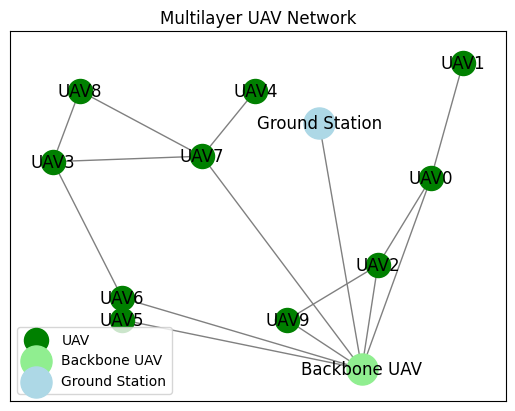

In [176]:
#Creating The Network First
# Initialize Simulation
simulation = UAVNetworkSimulation(URI, AUTH)

# Create and Setup UAV Network
uav_network = simulation.create_initial_graph(
    num_uavs, connection_range, ground_station_pos, backbone_range
)

# Upload to Neo4j
simulation.upload_to_neo4j(uav_network)

# Draw Initial Graph
simulation.draw_graph(uav_network)

# Close Neo4j Connection
simulation.close()


The graph is disconnected.


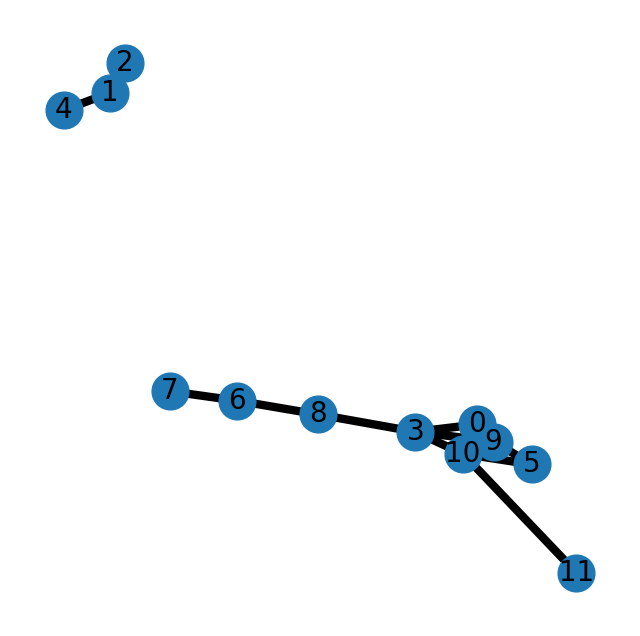

{'Number of UAVs': 12, 'Number of Connections': 14, 'Sparsity': 0.2121, 'Degree Centrality': {0: 0.2727272727272727, 1: 0.18181818181818182, 2: 0.09090909090909091, 3: 0.36363636363636365, 4: 0.09090909090909091, 5: 0.18181818181818182, 6: 0.18181818181818182, 7: 0.09090909090909091, 8: 0.18181818181818182, 9: 0.36363636363636365, 10: 0.4545454545454546, 11: 0.09090909090909091}, 'Closeness Centrality': {0: 0.36363636363636365, 1: 0.18181818181818182, 2: 0.12121212121212122, 3: 0.4475524475524476, 4: 0.12121212121212122, 5: 0.29090909090909095, 6: 0.27705627705627706, 7: 0.20779220779220778, 8: 0.36363636363636365, 9: 0.3878787878787879, 10: 0.41558441558441556, 11: 0.27705627705627706}, 'Betweenness Centrality': {0: 0.0, 1: 0.01818181818181818, 2: 0.0, 3: 0.2727272727272727, 4: 0.0, 5: 0.0, 6: 0.12727272727272726, 7: 0.0, 8: 0.21818181818181817, 9: 0.045454545454545456, 10: 0.17272727272727273, 11: 0.0}, 'Most Connected UAV': 10, 'Most Central UAV': 3, 'Most Critical UAV': 3, 'Connect

{'Number of UAVs': 12,
 'Number of Connections': 14,
 'Sparsity': 0.2121,
 'Degree Centrality': {0: 0.2727272727272727,
  1: 0.18181818181818182,
  2: 0.09090909090909091,
  3: 0.36363636363636365,
  4: 0.09090909090909091,
  5: 0.18181818181818182,
  6: 0.18181818181818182,
  7: 0.09090909090909091,
  8: 0.18181818181818182,
  9: 0.36363636363636365,
  10: 0.4545454545454546,
  11: 0.09090909090909091},
 'Closeness Centrality': {0: 0.36363636363636365,
  1: 0.18181818181818182,
  2: 0.12121212121212122,
  3: 0.4475524475524476,
  4: 0.12121212121212122,
  5: 0.29090909090909095,
  6: 0.27705627705627706,
  7: 0.20779220779220778,
  8: 0.36363636363636365,
  9: 0.3878787878787879,
  10: 0.41558441558441556,
  11: 0.27705627705627706},
 'Betweenness Centrality': {0: 0.0,
  1: 0.01818181818181818,
  2: 0.0,
  3: 0.2727272727272727,
  4: 0.0,
  5: 0.0,
  6: 0.12727272727272726,
  7: 0.0,
  8: 0.21818181818181817,
  9: 0.045454545454545456,
  10: 0.17272727272727273,
  11: 0.0},
 'Most Con

In [135]:
# perform network analysis
simulation.analyze_network(uav_network)


We run our movement simulation code, in the process UAVs can make new communications as they are currently routing fictional packets. We log the results below immediately and generate data based on our routing logic. Perform descriptive statistics.

Iteration 0:
  Packet 0: Source: 2, Target: 5, Size: 29, Delivered: False, Path: [], Total Latency: None
  Packet 1: Source: 7, Target: 6, Size: 46, Delivered: False, Path: [], Total Latency: None
  Packet 2: Source: 2, Target: 5, Size: 9, Delivered: False, Path: [], Total Latency: None
  Packet 3: Source: 7, Target: 3, Size: 48, Delivered: False, Path: [], Total Latency: None
  Packet 4: Source: 9, Target: 5, Size: 79, Delivered: False, Path: [], Total Latency: None
  Packet 5: Source: 3, Target: 6, Size: 1, Delivered: False, Path: [], Total Latency: None
  Packet 6: Source: 5, Target: 9, Size: 88, Delivered: False, Path: [], Total Latency: None
  Packet 7: Source: 5, Target: 2, Size: 6, Delivered: False, Path: [], Total Latency: None
  Packet 8: Source: 9, Target: 9, Size: 4, Delivered: True, Path: [9], Total Latency: 49
  Packet 9: Source: 3, Target: 0, Size: 11, Delivered: False, Path: [], Total Latency: None
Iteration 1:
  Packet 0: Source: 3, Target: 0, Size: 37, Delivered: False

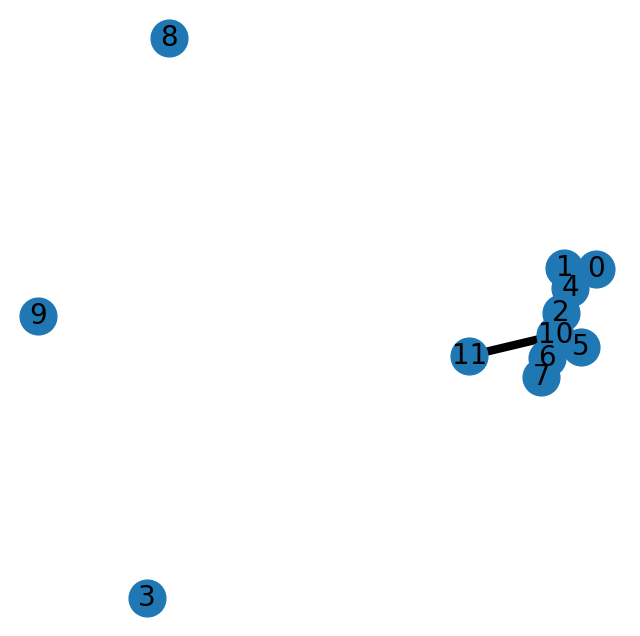

{'Number of UAVs': 12, 'Number of Connections': 8, 'Sparsity': 0.1212, 'Degree Centrality': {0: 0.09090909090909091, 1: 0.09090909090909091, 2: 0.18181818181818182, 3: 0.0, 4: 0.2727272727272727, 5: 0.09090909090909091, 6: 0.18181818181818182, 7: 0.09090909090909091, 8: 0.0, 9: 0.0, 10: 0.36363636363636365, 11: 0.09090909090909091}, 'Closeness Centrality': {0: 0.23272727272727273, 1: 0.23272727272727273, 2: 0.3878787878787879, 3: 0.0, 4: 0.3232323232323232, 5: 0.27705627705627706, 6: 0.3062200956937799, 7: 0.2237762237762238, 8: 0.0, 9: 0.0, 10: 0.41558441558441556, 11: 0.27705627705627706}, 'Betweenness Centrality': {0: 0.0, 1: 0.0, 2: 0.2727272727272727, 3: 0.0, 4: 0.23636363636363636, 5: 0.0, 6: 0.12727272727272726, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.3818181818181818, 11: 0.0}, 'Most Connected UAV': 10, 'Most Central UAV': 10, 'Most Critical UAV': 10, 'Connectivity': 0}
Metrics have been saved to MongoDB.


{'Number of UAVs': 12,
 'Number of Connections': 8,
 'Sparsity': 0.1212,
 'Degree Centrality': {0: 0.09090909090909091,
  1: 0.09090909090909091,
  2: 0.18181818181818182,
  3: 0.0,
  4: 0.2727272727272727,
  5: 0.09090909090909091,
  6: 0.18181818181818182,
  7: 0.09090909090909091,
  8: 0.0,
  9: 0.0,
  10: 0.36363636363636365,
  11: 0.09090909090909091},
 'Closeness Centrality': {0: 0.23272727272727273,
  1: 0.23272727272727273,
  2: 0.3878787878787879,
  3: 0.0,
  4: 0.3232323232323232,
  5: 0.27705627705627706,
  6: 0.3062200956937799,
  7: 0.2237762237762238,
  8: 0.0,
  9: 0.0,
  10: 0.41558441558441556,
  11: 0.27705627705627706},
 'Betweenness Centrality': {0: 0.0,
  1: 0.0,
  2: 0.2727272727272727,
  3: 0.0,
  4: 0.23636363636363636,
  5: 0.0,
  6: 0.12727272727272726,
  7: 0.0,
  8: 0.0,
  9: 0.0,
  10: 0.3818181818181818,
  11: 0.0},
 'Most Connected UAV': 10,
 'Most Central UAV': 10,
 'Most Critical UAV': 10,
 'Connectivity': 0}

In [156]:
"""Normal Network Simulation"""
# Run the Simulation
current_metrics = simulation.run_simulation(
    uav_network,
    total_time,
    update_interval,
    move_range,
    connection_range,
    backbone_range,
    num_packets,
)
# perform network analysis
simulation.analyze_network(uav_network)
# Close Neo4j Connection
simulation.close()

# simulation.plot_time_series(results)


Adding The Attack Node.

In [ ]:

# Target UAV ID for the DDoS attack
target_uav_ids = [5, 7]  # Example: Target UAV ID that you want to attack

# Add the attack node and connect it to the target UAV
attack_node_id = simulation.add_attack_node(uav_network, target_uav_ids, num_uavs)
simulation.upload_attack_node_to_neo4j(uav_network, attack_node_id, target_uav_ids)

# Close the Neo4j connection at the end of the session
simulation.close()


Iteration 0:


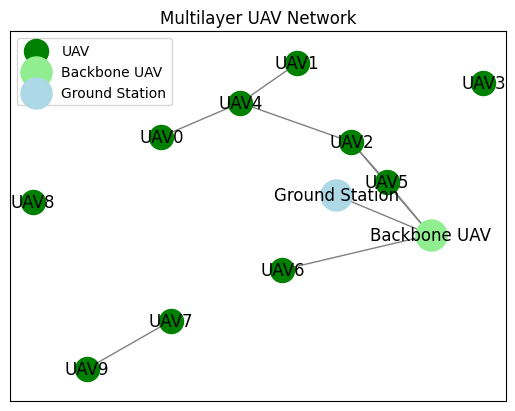

Packet 0: Source: 8, Target: 7, Size: 23, Delivered: False, Path: [], Total Latency: None
Packet 1: Source: 5, Target: 8, Size: 53, Delivered: False, Path: [], Total Latency: None
Packet 2: Source: 9, Target: 5, Size: 73, Delivered: False, Path: [], Total Latency: None
Packet 3: Source: 1, Target: 0, Size: 48, Delivered: True, Path: [1, 4, 0], Total Latency: 99
Packet 4: Source: 2, Target: 1, Size: 22, Delivered: True, Path: [2, 4, 1], Total Latency: 101
Packet 5: Source: 1, Target: 3, Size: 37, Delivered: False, Path: [], Total Latency: None
Packet 6: Source: 3, Target: 0, Size: 30, Delivered: False, Path: [], Total Latency: None
Packet 7: Source: 5, Target: 8, Size: 17, Delivered: False, Path: [], Total Latency: None
Packet 8: Source: 3, Target: 2, Size: 63, Delivered: False, Path: [], Total Latency: None
Packet 9: Source: 1, Target: 6, Size: 16, Delivered: True, Path: [1, 4, 2, 10, 6], Total Latency: 183
Iteration 1:


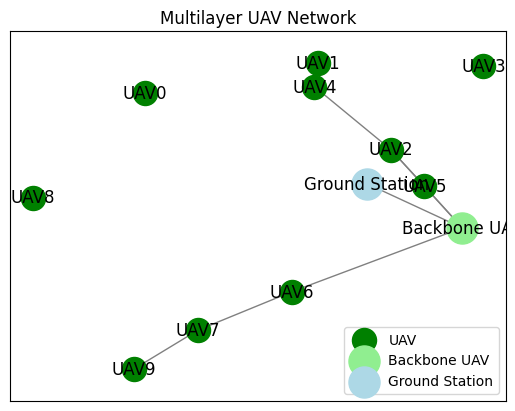

Packet 0: Source: 5, Target: 8, Size: 27, Delivered: False, Path: [], Total Latency: None
Packet 1: Source: 9, Target: 5, Size: 62, Delivered: True, Path: [9, 7, 6, 10, 5], Total Latency: 85
Packet 2: Source: 8, Target: 9, Size: 31, Delivered: False, Path: [], Total Latency: None
Packet 3: Source: 7, Target: 7, Size: 32, Delivered: True, Path: [7], Total Latency: 17
Packet 4: Source: 7, Target: 7, Size: 26, Delivered: True, Path: [7], Total Latency: 17
Packet 5: Source: 4, Target: 5, Size: 11, Delivered: True, Path: [4, 2, 5], Total Latency: 64
Packet 6: Source: 3, Target: 5, Size: 87, Delivered: False, Path: [], Total Latency: None
Packet 7: Source: 0, Target: 0, Size: 10, Delivered: True, Path: [0], Total Latency: 22
Packet 8: Source: 5, Target: 8, Size: 37, Delivered: False, Path: [], Total Latency: None
Packet 9: Source: 1, Target: 2, Size: 6, Delivered: True, Path: [1, 4, 2], Total Latency: 77
Iteration 2:


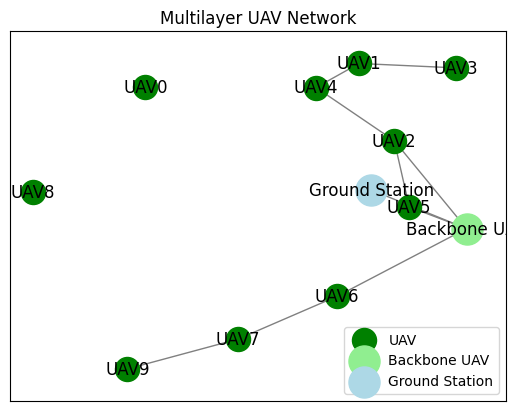

Packet 0: Source: 5, Target: 3, Size: 11, Delivered: True, Path: [5, 2, 4, 1, 3], Total Latency: 129
Packet 1: Source: 4, Target: 8, Size: 42, Delivered: False, Path: [], Total Latency: None
Packet 2: Source: 1, Target: 8, Size: 4, Delivered: False, Path: [], Total Latency: None
Packet 3: Source: 8, Target: 9, Size: 52, Delivered: False, Path: [], Total Latency: None
Packet 4: Source: 9, Target: 3, Size: 34, Delivered: True, Path: [9, 7, 6, 10, 2, 4, 1, 3], Total Latency: 182
Packet 5: Source: 2, Target: 6, Size: 21, Delivered: True, Path: [2, 10, 6], Total Latency: 38
Packet 6: Source: 2, Target: 3, Size: 3, Delivered: True, Path: [2, 4, 1, 3], Total Latency: 115
Packet 7: Source: 2, Target: 7, Size: 17, Delivered: True, Path: [2, 10, 6, 7], Total Latency: 55
Packet 8: Source: 1, Target: 1, Size: 77, Delivered: True, Path: [1], Total Latency: 30
Packet 9: Source: 3, Target: 9, Size: 23, Delivered: True, Path: [3, 1, 4, 2, 10, 6, 7, 9], Total Latency: 182
Iteration 3:


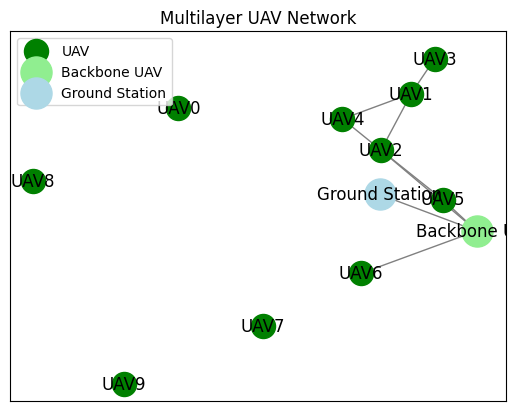

Packet 0: Source: 7, Target: 6, Size: 42, Delivered: False, Path: [], Total Latency: None
Packet 1: Source: 3, Target: 5, Size: 3, Delivered: True, Path: [3, 1, 2, 5], Total Latency: 95
Packet 2: Source: 1, Target: 6, Size: 59, Delivered: True, Path: [1, 2, 10, 6], Total Latency: 78
Packet 3: Source: 5, Target: 5, Size: 31, Delivered: True, Path: [5], Total Latency: 19
Packet 4: Source: 7, Target: 8, Size: 44, Delivered: False, Path: [], Total Latency: None
Packet 5: Source: 1, Target: 0, Size: 68, Delivered: False, Path: [], Total Latency: None
Packet 6: Source: 0, Target: 0, Size: 35, Delivered: True, Path: [0], Total Latency: 26
Packet 7: Source: 0, Target: 2, Size: 1, Delivered: False, Path: [], Total Latency: None
Packet 8: Source: 9, Target: 4, Size: 47, Delivered: False, Path: [], Total Latency: None
Packet 9: Source: 3, Target: 6, Size: 14, Delivered: True, Path: [3, 1, 2, 10, 6], Total Latency: 113
Iteration 4:


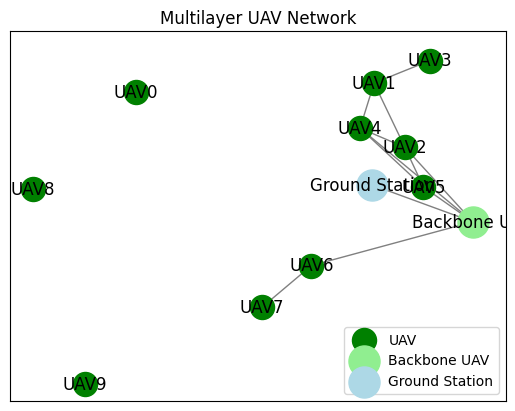

Packet 0: Source: 7, Target: 8, Size: 10, Delivered: False, Path: [], Total Latency: None
Packet 1: Source: 4, Target: 5, Size: 39, Delivered: True, Path: [4, 5], Total Latency: 51
Packet 2: Source: 5, Target: 9, Size: 16, Delivered: False, Path: [], Total Latency: None
Packet 3: Source: 1, Target: 0, Size: 1, Delivered: False, Path: [], Total Latency: None
Packet 4: Source: 5, Target: 7, Size: 27, Delivered: True, Path: [5, 10, 6, 7], Total Latency: 62
Packet 5: Source: 3, Target: 4, Size: 29, Delivered: True, Path: [3, 1, 4], Total Latency: 102
Packet 6: Source: 5, Target: 6, Size: 22, Delivered: True, Path: [5, 10, 6], Total Latency: 49
Packet 7: Source: 1, Target: 4, Size: 16, Delivered: True, Path: [1, 4], Total Latency: 68
Packet 8: Source: 0, Target: 4, Size: 28, Delivered: False, Path: [], Total Latency: None
Packet 9: Source: 4, Target: 9, Size: 11, Delivered: False, Path: [], Total Latency: None
Iteration 5:


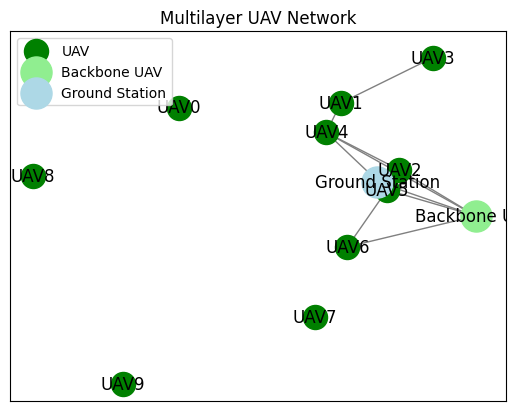

Packet 0: Source: 0, Target: 7, Size: 27, Delivered: False, Path: [], Total Latency: None
Packet 1: Source: 0, Target: 5, Size: 2, Delivered: False, Path: [], Total Latency: None
Packet 2: Source: 5, Target: 5, Size: 6, Delivered: True, Path: [5], Total Latency: 11
Packet 3: Source: 8, Target: 5, Size: 7, Delivered: False, Path: [], Total Latency: None
Packet 4: Source: 6, Target: 4, Size: 44, Delivered: True, Path: [6, 5, 4], Total Latency: 53
Packet 5: Source: 7, Target: 1, Size: 45, Delivered: False, Path: [], Total Latency: None
Packet 6: Source: 5, Target: 9, Size: 34, Delivered: False, Path: [], Total Latency: None
Packet 7: Source: 4, Target: 0, Size: 21, Delivered: False, Path: [], Total Latency: None
Packet 8: Source: 7, Target: 9, Size: 16, Delivered: False, Path: [], Total Latency: None
Packet 9: Source: 8, Target: 8, Size: 104, Delivered: True, Path: [8], Total Latency: 24
Iteration 6:


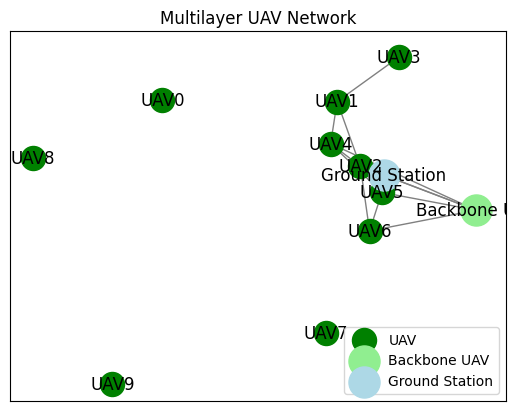

Packet 0: Source: 2, Target: 8, Size: 4, Delivered: False, Path: [], Total Latency: None
Packet 1: Source: 1, Target: 0, Size: 8, Delivered: False, Path: [], Total Latency: None
Packet 2: Source: 7, Target: 9, Size: 4, Delivered: False, Path: [], Total Latency: None
Packet 3: Source: 4, Target: 6, Size: 2, Delivered: True, Path: [4, 2, 6], Total Latency: 56
Packet 4: Source: 3, Target: 2, Size: 86, Delivered: True, Path: [3, 1, 2], Total Latency: 81
Packet 5: Source: 9, Target: 7, Size: 36, Delivered: False, Path: [], Total Latency: None
Packet 6: Source: 2, Target: 3, Size: 8, Delivered: True, Path: [2, 1, 3], Total Latency: 81
Packet 7: Source: 1, Target: 8, Size: 21, Delivered: False, Path: [], Total Latency: None
Packet 8: Source: 7, Target: 3, Size: 2, Delivered: False, Path: [], Total Latency: None
Packet 9: Source: 6, Target: 7, Size: 52, Delivered: False, Path: [], Total Latency: None
Iteration 7:


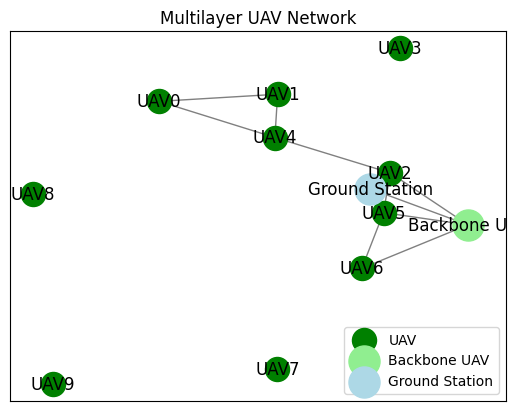

Packet 0: Source: 9, Target: 7, Size: 6, Delivered: False, Path: [], Total Latency: None
Packet 1: Source: 9, Target: 9, Size: 90, Delivered: True, Path: [9], Total Latency: 28
Packet 2: Source: 4, Target: 5, Size: 36, Delivered: True, Path: [4, 2, 5], Total Latency: 67
Packet 3: Source: 0, Target: 0, Size: 12, Delivered: True, Path: [0], Total Latency: 9
Packet 4: Source: 8, Target: 9, Size: 52, Delivered: False, Path: [], Total Latency: None
Packet 5: Source: 6, Target: 5, Size: 28, Delivered: True, Path: [6, 5], Total Latency: 26
Packet 6: Source: 8, Target: 9, Size: 20, Delivered: False, Path: [], Total Latency: None
Packet 7: Source: 4, Target: 5, Size: 8, Delivered: True, Path: [4, 2, 5], Total Latency: 67
Packet 8: Source: 6, Target: 9, Size: 34, Delivered: False, Path: [], Total Latency: None
Packet 9: Source: 2, Target: 3, Size: 26, Delivered: False, Path: [], Total Latency: None
Iteration 8:


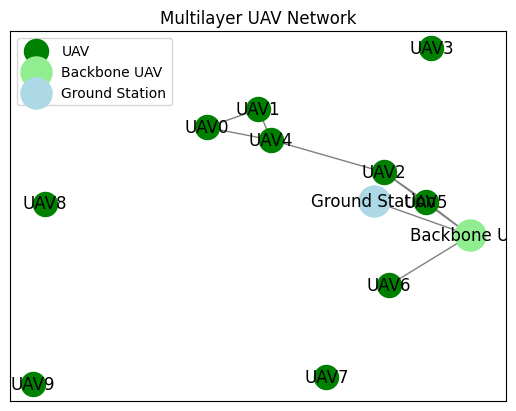

Packet 0: Source: 4, Target: 4, Size: 19, Delivered: True, Path: [4], Total Latency: 28
Packet 1: Source: 3, Target: 3, Size: 69, Delivered: True, Path: [3], Total Latency: 38
Packet 2: Source: 2, Target: 7, Size: 31, Delivered: False, Path: [], Total Latency: None
Packet 3: Source: 2, Target: 2, Size: 2, Delivered: True, Path: [2], Total Latency: 18
Packet 4: Source: 8, Target: 3, Size: 28, Delivered: False, Path: [], Total Latency: None
Packet 5: Source: 0, Target: 3, Size: 22, Delivered: False, Path: [], Total Latency: None
Packet 6: Source: 5, Target: 9, Size: 7, Delivered: False, Path: [], Total Latency: None
Packet 7: Source: 8, Target: 4, Size: 108, Delivered: False, Path: [], Total Latency: None
Packet 8: Source: 1, Target: 6, Size: 11, Delivered: True, Path: [1, 4, 2, 10, 6], Total Latency: 104
Packet 9: Source: 3, Target: 1, Size: 11, Delivered: False, Path: [], Total Latency: None
Iteration 9:


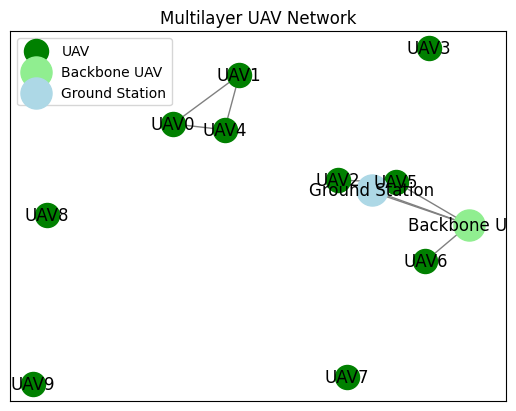

Packet 0: Source: 3, Target: 3, Size: 54, Delivered: True, Path: [3], Total Latency: 40
Packet 1: Source: 7, Target: 5, Size: 23, Delivered: False, Path: [], Total Latency: None
Packet 2: Source: 1, Target: 3, Size: 25, Delivered: False, Path: [], Total Latency: None
Packet 3: Source: 2, Target: 9, Size: 18, Delivered: False, Path: [], Total Latency: None
Packet 4: Source: 4, Target: 8, Size: 5, Delivered: False, Path: [], Total Latency: None
Packet 5: Source: 2, Target: 9, Size: 1, Delivered: False, Path: [], Total Latency: None
Packet 6: Source: 0, Target: 9, Size: 32, Delivered: False, Path: [], Total Latency: None
Packet 7: Source: 3, Target: 2, Size: 54, Delivered: False, Path: [], Total Latency: None
Packet 8: Source: 9, Target: 7, Size: 91, Delivered: False, Path: [], Total Latency: None
Packet 9: Source: 0, Target: 4, Size: 9, Delivered: True, Path: [0, 4], Total Latency: 36
Iteration 10:


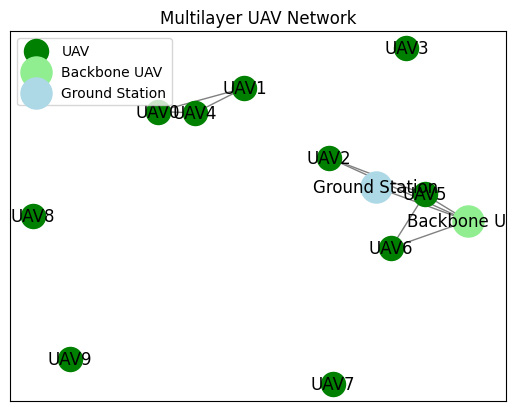

Packet 0: Source: 2, Target: 0, Size: 26, Delivered: False, Path: [], Total Latency: None
Packet 1: Source: 1, Target: 5, Size: 10, Delivered: False, Path: [], Total Latency: None
Packet 2: Source: 1, Target: 1, Size: 8, Delivered: True, Path: [1], Total Latency: 32
Packet 3: Source: 9, Target: 7, Size: 45, Delivered: False, Path: [], Total Latency: None
Packet 4: Source: 2, Target: 9, Size: 17, Delivered: False, Path: [], Total Latency: None
Packet 5: Source: 0, Target: 7, Size: 6, Delivered: False, Path: [], Total Latency: None
Packet 6: Source: 6, Target: 2, Size: 46, Delivered: True, Path: [6, 5, 2], Total Latency: 54
Packet 7: Source: 0, Target: 9, Size: 7, Delivered: False, Path: [], Total Latency: None
Packet 8: Source: 9, Target: 0, Size: 26, Delivered: False, Path: [], Total Latency: None
Packet 9: Source: 9, Target: 1, Size: 27, Delivered: False, Path: [], Total Latency: None
Iteration 11:


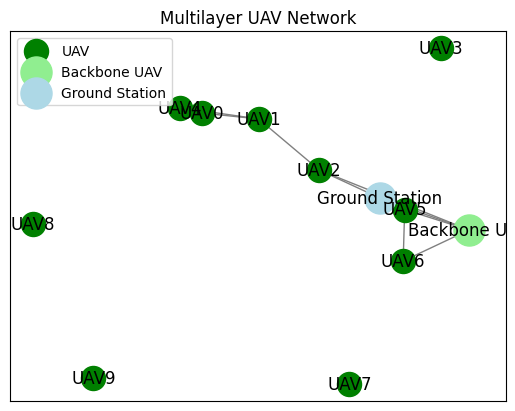

Packet 0: Source: 8, Target: 5, Size: 36, Delivered: False, Path: [], Total Latency: None
Packet 1: Source: 8, Target: 7, Size: 69, Delivered: False, Path: [], Total Latency: None
Packet 2: Source: 9, Target: 1, Size: 18, Delivered: False, Path: [], Total Latency: None
Packet 3: Source: 2, Target: 4, Size: 5, Delivered: True, Path: [2, 1, 4], Total Latency: 80
Packet 4: Source: 1, Target: 4, Size: 30, Delivered: True, Path: [1, 4], Total Latency: 60
Packet 5: Source: 7, Target: 2, Size: 5, Delivered: False, Path: [], Total Latency: None
Packet 6: Source: 2, Target: 2, Size: 8, Delivered: True, Path: [2], Total Latency: 20
Packet 7: Source: 8, Target: 6, Size: 31, Delivered: False, Path: [], Total Latency: None
Packet 8: Source: 0, Target: 3, Size: 13, Delivered: False, Path: [], Total Latency: None
Packet 9: Source: 3, Target: 0, Size: 69, Delivered: False, Path: [], Total Latency: None
Iteration 12:


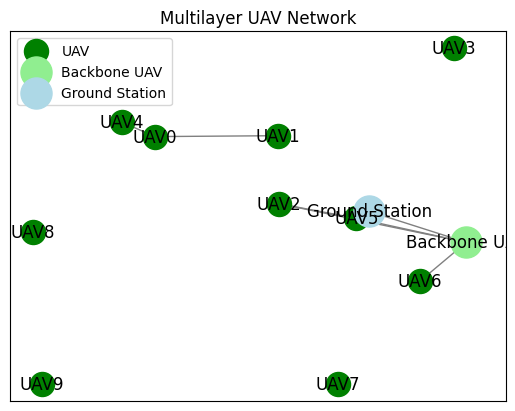

Packet 0: Source: 5, Target: 4, Size: 8, Delivered: False, Path: [], Total Latency: None
Packet 1: Source: 9, Target: 6, Size: 99, Delivered: False, Path: [], Total Latency: None
Packet 2: Source: 9, Target: 7, Size: 63, Delivered: False, Path: [], Total Latency: None
Packet 3: Source: 6, Target: 2, Size: 20, Delivered: True, Path: [6, 10, 2], Total Latency: 52
Packet 4: Source: 5, Target: 8, Size: 29, Delivered: False, Path: [], Total Latency: None
Packet 5: Source: 4, Target: 4, Size: 44, Delivered: True, Path: [4], Total Latency: 22
Packet 6: Source: 6, Target: 3, Size: 15, Delivered: False, Path: [], Total Latency: None
Packet 7: Source: 8, Target: 6, Size: 61, Delivered: False, Path: [], Total Latency: None
Packet 8: Source: 9, Target: 0, Size: 91, Delivered: False, Path: [], Total Latency: None
Packet 9: Source: 9, Target: 7, Size: 28, Delivered: False, Path: [], Total Latency: None
Iteration 13:


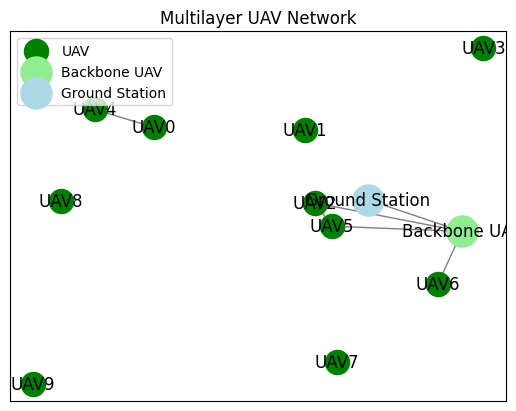

Packet 0: Source: 1, Target: 5, Size: 7, Delivered: False, Path: [], Total Latency: None
Packet 1: Source: 4, Target: 3, Size: 36, Delivered: False, Path: [], Total Latency: None
Packet 2: Source: 9, Target: 0, Size: 96, Delivered: False, Path: [], Total Latency: None
Packet 3: Source: 6, Target: 1, Size: 10, Delivered: False, Path: [], Total Latency: None
Packet 4: Source: 5, Target: 6, Size: 22, Delivered: True, Path: [5, 10, 6], Total Latency: 40
Packet 5: Source: 3, Target: 7, Size: 44, Delivered: False, Path: [], Total Latency: None
Packet 6: Source: 0, Target: 8, Size: 15, Delivered: False, Path: [], Total Latency: None
Packet 7: Source: 6, Target: 0, Size: 32, Delivered: False, Path: [], Total Latency: None
Packet 8: Source: 5, Target: 4, Size: 27, Delivered: False, Path: [], Total Latency: None
Packet 9: Source: 4, Target: 3, Size: 57, Delivered: False, Path: [], Total Latency: None
Iteration 14:


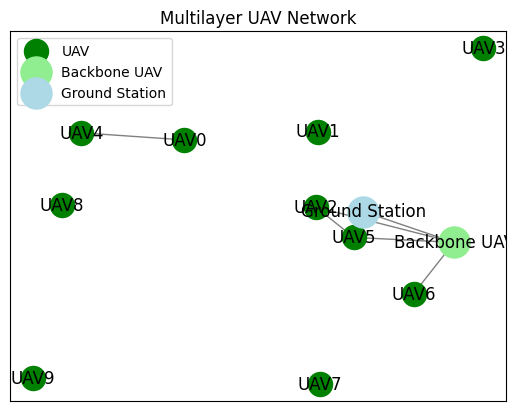

Packet 0: Source: 2, Target: 8, Size: 6, Delivered: False, Path: [], Total Latency: None
Packet 1: Source: 9, Target: 0, Size: 41, Delivered: False, Path: [], Total Latency: None
Packet 2: Source: 4, Target: 7, Size: 58, Delivered: False, Path: [], Total Latency: None
Packet 3: Source: 7, Target: 5, Size: 18, Delivered: False, Path: [], Total Latency: None
Packet 4: Source: 7, Target: 0, Size: 20, Delivered: False, Path: [], Total Latency: None
Packet 5: Source: 1, Target: 5, Size: 33, Delivered: False, Path: [], Total Latency: None
Packet 6: Source: 5, Target: 2, Size: 4, Delivered: True, Path: [5, 2], Total Latency: 33
Packet 7: Source: 9, Target: 5, Size: 60, Delivered: False, Path: [], Total Latency: None
Packet 8: Source: 0, Target: 7, Size: 7, Delivered: False, Path: [], Total Latency: None
Packet 9: Source: 9, Target: 4, Size: 51, Delivered: False, Path: [], Total Latency: None
Iteration 15:


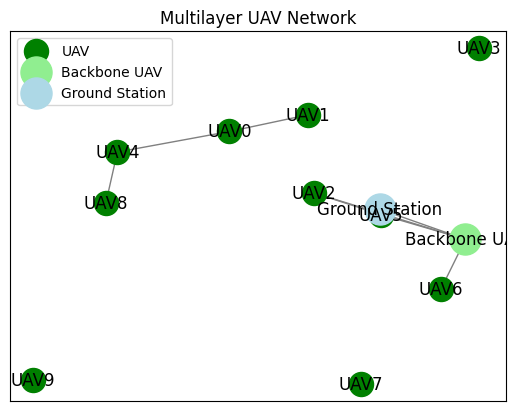

Packet 0: Source: 9, Target: 1, Size: 36, Delivered: False, Path: [], Total Latency: None
Packet 1: Source: 3, Target: 3, Size: 24, Delivered: True, Path: [3], Total Latency: 27
Packet 2: Source: 5, Target: 4, Size: 1, Delivered: False, Path: [], Total Latency: None
Packet 3: Source: 4, Target: 8, Size: 55, Delivered: True, Path: [4, 8], Total Latency: 39
Packet 4: Source: 6, Target: 5, Size: 49, Delivered: True, Path: [6, 10, 5], Total Latency: 40
Packet 5: Source: 7, Target: 7, Size: 12, Delivered: True, Path: [7], Total Latency: 6
Packet 6: Source: 3, Target: 4, Size: 24, Delivered: False, Path: [], Total Latency: None
Packet 7: Source: 9, Target: 7, Size: 32, Delivered: False, Path: [], Total Latency: None
Packet 8: Source: 2, Target: 0, Size: 5, Delivered: False, Path: [], Total Latency: None
Packet 9: Source: 9, Target: 8, Size: 65, Delivered: False, Path: [], Total Latency: None
Iteration 16:


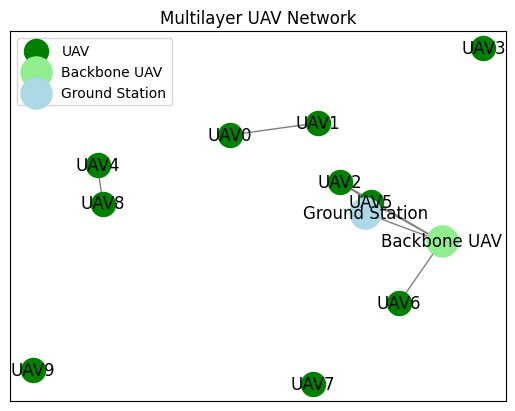

Packet 0: Source: 4, Target: 5, Size: 3, Delivered: False, Path: [], Total Latency: None
Packet 1: Source: 8, Target: 9, Size: 75, Delivered: False, Path: [], Total Latency: None
Packet 2: Source: 5, Target: 9, Size: 2, Delivered: False, Path: [], Total Latency: None
Packet 3: Source: 4, Target: 3, Size: 24, Delivered: False, Path: [], Total Latency: None
Packet 4: Source: 6, Target: 7, Size: 71, Delivered: False, Path: [], Total Latency: None
Packet 5: Source: 8, Target: 0, Size: 124, Delivered: False, Path: [], Total Latency: None
Packet 6: Source: 0, Target: 4, Size: 8, Delivered: False, Path: [], Total Latency: None
Packet 7: Source: 7, Target: 4, Size: 15, Delivered: False, Path: [], Total Latency: None
Packet 8: Source: 8, Target: 1, Size: 84, Delivered: False, Path: [], Total Latency: None
Packet 9: Source: 9, Target: 1, Size: 68, Delivered: False, Path: [], Total Latency: None
Metrics have been saved to MongoDB.


In [157]:
#DDoS Simulation
# Run the DDoS simulation
simulation.run_ddos_simulation(uav_network, total_time, update_interval, ddos_move_range, connection_range, backbone_range, num_packets, target_ids)

# Close the Neo4j connection at the end of the session
simulation.close()

Descriptive Statistics, Performing Correlation Analysis On the Dataset and plotting correlation matrix.

In [ ]:
import matplotlib.pyplot as plt
metrics = simulation.run_ddos_simulation(uav_network, total_time, update_interval, move_range, connection_range, backbone_range, num_packets, attack_node_id, target_ids)

def plot_network_metrics(metrics):
    # Assuming metrics is a list of tuples (node_id, time, latency, throughput, battery)
    # Filter by node_id for node 5 and node 7
    times_5 = [m[1] for m in metrics if m[0] == 5]
    latencies_5 = [m[2] for m in metrics if m[0] == 5]
    throughputs_5 = [m[3] for m in metrics if m[0] == 5]

    times_7 = [m[1] for m in metrics if m[0] == 7]
    latencies_7 = [m[2] for m in metrics if m[0] == 7]
    throughputs_7 = [m[3] for m in metrics if m[0] == 7]

    plt.figure(figsize=(12, 6))
    
    plt.subplot(2, 1, 1)
    plt.plot(times_5, latencies_5, label='Latency UAV 5')
    plt.plot(times_7, latencies_7, label='Latency UAV 7')
    plt.title('Latency over Time')
    plt.xlabel('Time (s)')
    plt.ylabel('Latency (ms)')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(times_5, throughputs_5, label='Throughput UAV 5')
    plt.plot(times_7, throughputs_7, label='Throughput UAV 7')
    plt.title('Throughput over Time')
    plt.xlabel('Time (s)')
    plt.ylabel('Throughput (Mbps)')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
if metrics:
    plot_network_metrics(metrics)
else:
    print("No data was returned from the simulation.")
# Example usage:
# metrics = [(5, 1.0, 50, 100), (7, 1.0, 70, 90), (5, 2.0, 55, 95), (7, 2.0, 75, 85)]
# plot_network_metrics(metrics)


In [ ]:
"""Pearson's Correlation"""

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Data provided
data = [
    {'time': 0.001983642578125, 'node_id': 0, 'latency': 16, 'throughput': 71},
    {'time': 0.001983642578125, 'node_id': 1, 'latency': 41, 'throughput': 54},
    {'time': 0.001983642578125, 'node_id': 2, 'latency': 32, 'throughput': 76},
    {'time': 0.001983642578125, 'node_id': 3, 'latency': 7, 'throughput': 52},
    {'time': 0.001983642578125, 'node_id': 4, 'latency': 18, 'throughput': 53},
    {'time': 0.001983642578125, 'node_id': 5, 'latency': 17, 'throughput': 65},
    {'time': 0.001983642578125, 'node_id': 6, 'latency': 16, 'throughput': 84},
    {'time': 0.001983642578125, 'node_id': 7, 'latency': 40, 'throughput': 55},
    {'time': 0.001983642578125, 'node_id': 8, 'latency': 37, 'throughput': 68},
    {'time': 0.001983642578125, 'node_id': 9, 'latency': 39, 'throughput': 77},
    {'time': 0.001983642578125, 'node_id': 10, 'latency': 36, 'throughput': 86},
    {'time': 0.001983642578125, 'node_id': 11, 'latency': 39, 'throughput': 94},
    {'time': 5.015164613723755, 'node_id': 0, 'latency': 17, 'throughput': 78},
    # Assuming the rest of the data points are appended here in the same format...
]

# Converting data into a pandas DataFrame
df = pd.DataFrame(data)

# Calculating the correlation between latency and throughput
correlation_matrix = df[['latency', 'throughput']].corr()
print(correlation_matrix)


# Plotting a heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
heatmap.set_title('Correlation Heatmap between Latency and Throughput', pad=12)
plt.show()


In [ ]:
def plot_network_metrics_from_csv(file_path):
    # Load data from CSV
    df = pd.read_csv(file_path)
    
    # Filter data for specific nodes
    node_5_df = df[df['Node'] == 5]
    node_7_df = df[df['Node'] == 7]
    
    # Extract times, latencies, and throughputs
    times_5 = node_5_df['Time']
    latencies_5 = node_5_df['Latency']
    throughputs_5 = node_5_df['Throughput']

    times_7 = node_7_df['Time']
    latencies_7 = node_7_df['Latency']
    throughputs_7 = node_7_df['Throughput']

    plt.figure(figsize=(12, 6))
    
    plt.subplot(2, 1, 1)
    plt.plot(times_5, latencies_5, label='Latency UAV 5')
    plt.plot(times_7, latencies_7, label='Latency UAV 7')
    plt.title('Latency over Time')
    plt.xlabel('Time (s)')
    plt.ylabel('Latency (ms)')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(times_5, throughputs_5, label='Throughput UAV 5')
    plt.plot(times_7, throughputs_7, label='Throughput UAV 7')
    plt.title('Throughput over Time')
    plt.xlabel('Time (s)')
    plt.ylabel('Throughput (Mbps)')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage:
file_path = 'simulation_results\ddos_simulation_20240423_012712.csv'
plot_network_metrics_from_csv(file_path)


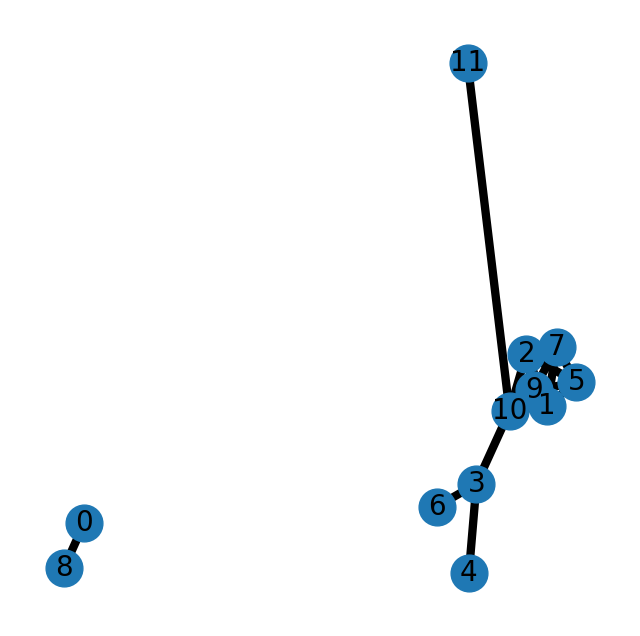

{'Number of Nodes': 12, 'Number of Edges': 18, 'Sparsity': 0.2727272727272727, 'Degree Centrality': {0: 0.09090909090909091, 1: 0.4545454545454546, 2: 0.4545454545454546, 3: 0.2727272727272727, 4: 0.09090909090909091, 5: 0.36363636363636365, 6: 0.09090909090909091, 7: 0.36363636363636365, 8: 0.09090909090909091, 9: 0.4545454545454546, 10: 0.4545454545454546, 11: 0.09090909090909091}, 'Closeness Centrality': {0: 0.09090909090909091, 1: 0.4909090909090909, 2: 0.4909090909090909, 3: 0.43315508021390375, 4: 0.29454545454545455, 5: 0.3681818181818182, 6: 0.29454545454545455, 7: 0.3681818181818182, 8: 0.09090909090909091, 9: 0.4909090909090909, 10: 0.5664335664335665, 11: 0.35064935064935066}, 'Betweenness Centrality': {0: 0.0, 1: 0.06060606060606061, 2: 0.06060606060606061, 3: 0.2727272727272727, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.06060606060606061, 10: 0.41818181818181815, 11: 0.0}, 'Most Connected Node': 1, 'Most Central Node': 10, 'Most Critical Node': 10, 'Connectivity': 0}
Me

{'Number of Nodes': 12,
 'Number of Edges': 18,
 'Sparsity': 0.2727272727272727,
 'Degree Centrality': {0: 0.09090909090909091,
  1: 0.4545454545454546,
  2: 0.4545454545454546,
  3: 0.2727272727272727,
  4: 0.09090909090909091,
  5: 0.36363636363636365,
  6: 0.09090909090909091,
  7: 0.36363636363636365,
  8: 0.09090909090909091,
  9: 0.4545454545454546,
  10: 0.4545454545454546,
  11: 0.09090909090909091},
 'Closeness Centrality': {0: 0.09090909090909091,
  1: 0.4909090909090909,
  2: 0.4909090909090909,
  3: 0.43315508021390375,
  4: 0.29454545454545455,
  5: 0.3681818181818182,
  6: 0.29454545454545455,
  7: 0.3681818181818182,
  8: 0.09090909090909091,
  9: 0.4909090909090909,
  10: 0.5664335664335665,
  11: 0.35064935064935066},
 'Betweenness Centrality': {0: 0.0,
  1: 0.06060606060606061,
  2: 0.06060606060606061,
  3: 0.2727272727272727,
  4: 0.0,
  5: 0.0,
  6: 0.0,
  7: 0.0,
  8: 0.0,
  9: 0.06060606060606061,
  10: 0.41818181818181815,
  11: 0.0},
 'Most Connected Node': 1,


In [104]:
#perform network analysis
simulation = UAVNetworkSimulation(URI, AUTH)
simulation.analyze_network(uav_network)

In [ ]:
import pandas as pd


def descriptive_statistics(file_path):
    # Load the CSV file into a DataFrame
    df = pd.read_csv(file_path)

    # Compute descriptive statistics
    stats = (
        df.describe()
    )  # Get count, mean, std, min, 25%, 50%, 75%, max for numerical columns

    # Additional detailed statistics
    mean_values = df.mean()  # Mean
    median_values = df.median()  # Median
    mode_values = df.mode().iloc[0]  # Mode (first mode in case of multi-modal data)
    std_values = df.std()  # Standard deviation
    var_values = df.var()  # Variance
    min_values = df.min()  # Minimum
    max_values = df.max()  # Maximum

    # Print statistics
    print("Basic Descriptive Statistics:")
    print(stats)

    print("\nMean Values:")
    print(mean_values)

    print("\nMedian Values:")
    print(median_values)

    print("\nMode Values:")
    print(mode_values)

    print("\nStandard Deviation:")
    print(std_values)

    print("\nVariance:")
    print(var_values)

    print("\nMinimum Values:")
    print(min_values)

    print("\nMaximum Values:")
    print(max_values)


# Example usage:
file_path = "simulation_results\ddos_simulation_20240426_030300.csv"
descriptive_statistics(file_path)
